In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

2023-04-16 21:36:18.883979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:36:19.057746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:36:19.058501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 21:36:20.016108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset_path = os.listdir('MangoLeafBD')
print(dataset_path)

['Sooty Mould', 'Powdery Mildew', 'Gall Midge', 'Cutting Weevil', 'Die Back', 'Bacterial Canker', 'Anthracnose', 'Healthy']


In [3]:
class_labels = []

for item in dataset_path:
 # Get all the file names
    all_classes = os.listdir('MangoLeafBD' + '/' +item)
 #print(all_classes)

 # Add them to the list
    for room in all_classes:
        class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))

In [4]:
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())

        Labels                                              image
0  Sooty Mould  dataset_path/Sooty Mould/IMG_20211108_121559 (...
1  Sooty Mould  dataset_path/Sooty Mould/IMG_20211211_154825 (...
2  Sooty Mould  dataset_path/Sooty Mould/IMG_20211211_154608 (...
3  Sooty Mould  dataset_path/Sooty Mould/IMG_20211211_154225 (...
4  Sooty Mould  dataset_path/Sooty Mould/IMG_20211211_154252 (...


In [5]:
print(df.tail())

       Labels                                              image
3995  Healthy  dataset_path/Healthy/20211231_155753 (Custom).jpg
3996  Healthy  dataset_path/Healthy/20211231_125054 (Custom).jpg
3997  Healthy  dataset_path/Healthy/20211231_161108 (Custom).jpg
3998  Healthy  dataset_path/Healthy/20211231_124957 (Custom).jpg
3999  Healthy  dataset_path/Healthy/20211231_160229 (Custom).jpg


In [6]:
print(df['Labels'].value_counts())

Sooty Mould         500
Powdery Mildew      500
Gall Midge          500
Cutting Weevil      500
Die Back            500
Bacterial Canker    500
Anthracnose         500
Healthy             500
Name: Labels, dtype: int64


In [7]:
path = 'MangoLeafBD/'

im_size = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path)]
    
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [8]:
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(4000, 224, 224, 3)

In [9]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['Sooty Mould' 'Sooty Mould' 'Sooty Mould' ... 'Healthy' 'Healthy'
 'Healthy']
[7 7 7 ... 5 5 5]


In [10]:
y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()


In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(3200, 224, 224, 3)
(3200, 8)
(800, 224, 224, 3)
(800, 8)


In [12]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import NASNetMobile

In [13]:
NUM_CLASSES = 8
IMG_SIZE = 224

In [14]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = NASNetMobile(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.Flatten()(model.output)
#     x = layers.BatchNormalization()(x)

#     top_dropout_rate = 0.2
#     x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="NASNetMobile")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [15]:
model = build_model(num_classes=NUM_CLASSES)


2023-04-16 21:36:29.914606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 21:36:29.915552: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("NASNetMobile Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["train", "validation"], loc="upper left")
    plt.grid()
    plt.savefig('NASNetMobile_acc',dpi=300)
    plt.show()

In [17]:
epochs = 5


hist = model.fit(train_x, train_y, epochs=epochs, verbose=2)
    

2023-04-16 21:36:34.126036: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1926758400 exceeds 10% of free system memory.


Epoch 1/5
100/100 - 64s - loss: 1.1828 - accuracy: 0.8497 - 64s/epoch - 644ms/step
Epoch 2/5
100/100 - 53s - loss: 0.1191 - accuracy: 0.9775 - 53s/epoch - 531ms/step
Epoch 3/5
100/100 - 54s - loss: 0.0811 - accuracy: 0.9825 - 54s/epoch - 538ms/step
Epoch 4/5
100/100 - 54s - loss: 0.0536 - accuracy: 0.9862 - 54s/epoch - 538ms/step
Epoch 5/5
100/100 - 55s - loss: 0.0763 - accuracy: 0.9837 - 55s/epoch - 549ms/step


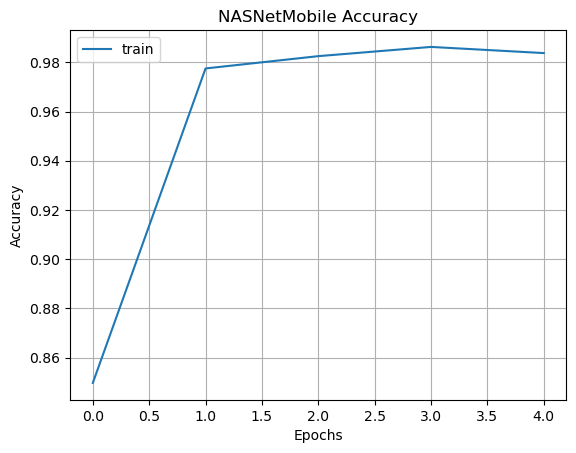

In [18]:
plot_hist(hist)

In [19]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2023-04-16 21:41:18.130881: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 481689600 exceeds 10% of free system memory.


25/25 [==============================] - 19s 611ms/step - loss: 0.2729 - accuracy: 0.9613
Loss = 0.2728748321533203
Test Accuracy = 0.9612500071525574


In [20]:
import pickle

In [21]:
with open('NASNetMobileHistory','wb') as f:
    pickle.dump(hist.history,f)

In [22]:
df = pd.DataFrame.from_dict(hist.history)
df.to_csv('NASNetMobile_history.csv')

In [23]:
model.save('NASNetMobile_detect.h5')

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
test_y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
test_y = np.argmax(test_y, axis=1)
test_y

array([5, 2, 0, 0, 1, 4, 1, 1, 2, 5, 0, 0, 3, 1, 6, 0, 6, 4, 2, 4, 4, 2,
       5, 3, 2, 3, 0, 0, 6, 4, 1, 2, 7, 2, 5, 7, 0, 1, 1, 5, 1, 7, 5, 5,
       4, 0, 6, 4, 7, 1, 2, 1, 0, 2, 0, 2, 7, 0, 6, 0, 6, 0, 3, 7, 0, 6,
       2, 4, 3, 1, 3, 1, 3, 5, 7, 5, 3, 4, 7, 6, 2, 2, 5, 0, 5, 2, 7, 6,
       4, 1, 1, 0, 0, 4, 0, 3, 3, 3, 1, 2, 7, 5, 0, 4, 2, 1, 5, 0, 5, 0,
       3, 3, 0, 7, 6, 6, 3, 6, 6, 6, 4, 1, 6, 0, 1, 4, 7, 5, 5, 3, 1, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 1, 5, 5, 4, 3, 1, 5, 7, 6, 7, 3, 0, 4, 5,
       7, 5, 1, 5, 5, 3, 1, 2, 5, 4, 6, 1, 2, 3, 5, 6, 4, 3, 4, 1, 5, 2,
       2, 7, 2, 3, 1, 2, 4, 4, 5, 4, 7, 0, 7, 4, 3, 6, 1, 0, 7, 7, 6, 0,
       7, 3, 5, 5, 7, 6, 5, 3, 2, 0, 4, 6, 2, 2, 3, 2, 6, 7, 2, 6, 0, 2,
       1, 4, 2, 6, 1, 4, 4, 4, 6, 6, 4, 7, 7, 0, 2, 5, 3, 0, 7, 4, 2, 1,
       2, 3, 4, 1, 1, 2, 0, 6, 7, 1, 4, 0, 5, 4, 4, 1, 6, 6, 1, 1, 0, 2,
       4, 1, 7, 0, 4, 6, 4, 0, 1, 4, 0, 5, 2, 4, 0, 3, 6, 7, 6, 4, 2, 1,
       5, 0, 2, 6, 6, 2, 6, 1, 7, 4, 7, 3, 0, 6, 1,

In [28]:
pred_y = model.predict(test_x)
pred_y

2023-04-16 21:45:52.987920: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 481689600 exceeds 10% of free system memory.


25/25 [==============================] - 17s 569ms/step


array([[7.1081433e-18, 2.2867703e-23, 3.4910742e-38, ..., 9.9999994e-01,
        2.8287264e-35, 2.0244058e-23],
       [3.4707227e-28, 1.2766357e-15, 9.9999994e-01, ..., 4.5606733e-32,
        0.0000000e+00, 1.1751269e-24],
       [9.9999994e-01, 3.6819925e-10, 3.2225338e-26, ..., 1.5988979e-11,
        2.7287063e-27, 3.4608704e-22],
       ...,
       [9.9999970e-01, 1.1789811e-13, 2.0880367e-31, ..., 6.8832511e-17,
        9.1488854e-19, 1.5206061e-15],
       [2.4911473e-03, 1.8241201e-08, 5.2729756e-26, ..., 1.9150574e-04,
        4.1349222e-06, 1.9194252e-08],
       [2.8146159e-12, 9.5352858e-11, 1.1492154e-31, ..., 1.1281117e-21,
        1.0595111e-23, 1.6207430e-20]], dtype=float32)

In [31]:
pred_y = np.argmax(pred_y, axis=1)
pred_y

array([5, 2, 0, 0, 1, 4, 1, 1, 2, 5, 0, 0, 3, 1, 6, 0, 6, 4, 2, 4, 4, 2,
       5, 3, 2, 3, 0, 0, 7, 4, 1, 2, 7, 2, 5, 7, 4, 1, 1, 5, 4, 7, 0, 5,
       4, 0, 6, 4, 7, 1, 2, 1, 0, 2, 0, 2, 7, 0, 6, 0, 6, 0, 3, 7, 0, 6,
       2, 1, 3, 1, 3, 1, 3, 5, 7, 5, 3, 4, 7, 6, 2, 2, 5, 0, 5, 2, 7, 6,
       4, 1, 1, 0, 0, 4, 0, 3, 3, 3, 1, 2, 7, 5, 0, 4, 2, 1, 5, 0, 5, 0,
       3, 3, 0, 7, 6, 6, 3, 6, 6, 7, 4, 4, 6, 0, 1, 4, 7, 5, 5, 3, 1, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 1, 5, 5, 4, 6, 1, 5, 7, 6, 7, 3, 0, 4, 5,
       7, 5, 1, 5, 5, 3, 1, 2, 5, 4, 6, 1, 2, 3, 5, 6, 4, 3, 4, 1, 5, 2,
       2, 7, 2, 3, 1, 2, 4, 1, 5, 4, 7, 0, 7, 4, 3, 6, 1, 4, 7, 7, 6, 0,
       7, 3, 5, 5, 7, 6, 5, 3, 2, 0, 4, 6, 2, 2, 0, 2, 6, 7, 2, 6, 0, 2,
       1, 4, 2, 6, 1, 4, 4, 4, 6, 6, 4, 7, 7, 0, 2, 5, 3, 0, 7, 4, 2, 1,
       2, 3, 4, 1, 1, 2, 0, 6, 7, 1, 4, 0, 5, 4, 3, 1, 6, 6, 1, 1, 0, 2,
       4, 1, 7, 0, 4, 6, 4, 0, 1, 4, 0, 5, 2, 4, 4, 3, 6, 7, 7, 4, 2, 1,
       5, 0, 2, 6, 6, 2, 6, 1, 7, 1, 7, 3, 0, 6, 1,

In [33]:
result = confusion_matrix(test_y, pred_y)

In [34]:
result

array([[110,   0,   0,   0,   6,   0,   0,   0],
       [  0,  97,   0,   0,   2,   0,   0,   0],
       [  0,   0, 102,   0,   0,   0,   0,   0],
       [  3,   0,   0,  82,   0,   0,   3,   0],
       [  2,   5,   0,   1,  95,   0,   1,   1],
       [  1,   0,   0,   0,   0,  98,   0,   0],
       [  0,   0,   0,   1,   0,   0,  96,   3],
       [  1,   0,   0,   0,   1,   0,   0,  89]])